In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw
import os
import shutil

In [2]:
path = os.path.join('emojis')
isExists = os.path.exists(path)
if not isExists:
    os.mkdir(path)

In [3]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

In [4]:
def add_image_to_emojis_folder():
    for i in range(len(emojis)):
        path = emojis[i]['file']
        img_path = os.path.join('all_emojis', path)
        dest_path = os.path.join('emojis')
        shutil.copy(img_path, dest_path)

add_image_to_emojis_folder()

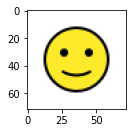

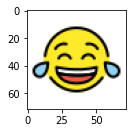

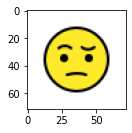

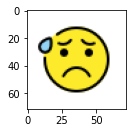

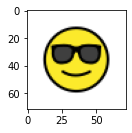

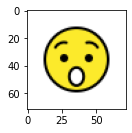

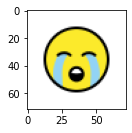

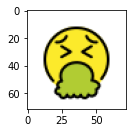

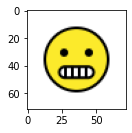

In [5]:
def show_img():
    for i in range(len(emojis)):
        path = emojis[i]['file']
        img_path = os.path.join('emojis', path)
        png_file = Image.open(img_path).convert('RGBA')
        png_file.load()
        new_file = Image.new("RGB", png_file.size, (255, 255, 255))
        new_file.paste(png_file, mask=png_file.split()[3])
        emojis[i]['image'] = new_file 
        
        image = np.array(new_file)
        plt.subplots(1)
        plt.subplot(222)
        plt.imshow(image)
        
show_img()

In [6]:
def create_more_examples():
    background = np.ones((144,144,3))*255
    row = np.random.randint(0,72)
    col = np.random.randint(0,72)
    
    img_num = np.random.randint(0,9)
    
    background[row:row+72, col:col+72, :] = np.array(emojis[img_num]['image'])
    background = background.astype('uint8')
    plt.imshow(background)
    plt.title(emojis[img_num]['name'], c = 'w')
    return background, img_num, row, col 

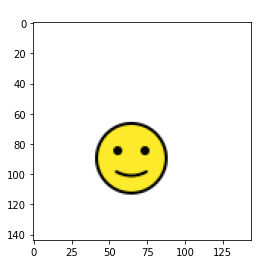

In [7]:
image, class_id, row, col = create_more_examples()

uint8


Text(0.5, 1.0, 'happy')

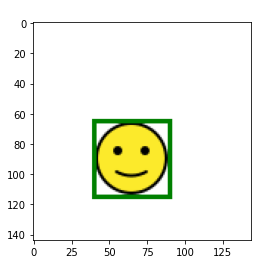

In [8]:
def plot_bounding_box(image, y_true_coords, y_pred_coords = []):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    row, col = y_true_coords
    draw.rectangle((col+10,row+10,col+62,row+62), outline = 'green', width=3)
    if(len(y_pred_coords)==2):
        row, col = y_pred_coords
        draw.rectangle((col+10,row+10,col+62,row+62), outline = 'red', width=3)
    
    return image
print(image.dtype)
image2 = plot_bounding_box(image, [row, col])
plt.imshow(image2)
plt.title(emojis[class_id]['name'], c = 'w')

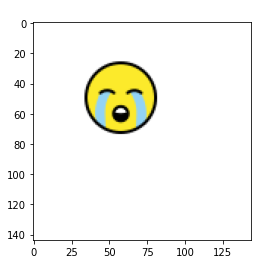

In [9]:
def create_training_dataset_static():
    x_train = np.zeros((200,144,144,3), dtype=np.uint8)
    y_train = np.zeros((200, 11), dtype=np.uint8)
    for i in range(200):
        image, class_id, row, col = create_more_examples()
        image = image
        x_train[i] = image.astype('uint8')
#         y_train[i, 0] = 1
        y_train[i, 0:2] = row, col
        y_train[i, class_id+2] = 1 
    return x_train, y_train
x_train, y_train = create_training_dataset_static()        

In [10]:
x_train.shape

(200, 144, 144, 3)

In [11]:
y_train.shape

(200, 11)

27 36


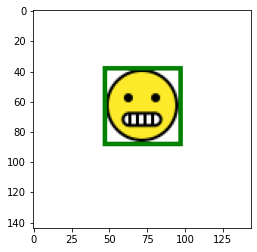

In [12]:
row = y_train[29, 0]
col = y_train[29, 1]
print(row, col)
image3 = plot_bounding_box(x_train[29],[row, col])
plt.imshow(image3)

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense

In [14]:
def feature_extract(inputs):
    x = inputs
    for i in range(0, 5):
        n_filters = 2**(4+i)
        x = Conv2D(n_filters, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(2)(x)
    return x

def dense_layer(inputs):
    x = Flatten()(inputs)
    x = Dense(100, activation = 'relu')(x)
    return x

def classifier(inputs):
    x = Dense(9, activation='softmax', name = 'classifier')(inputs)
    return x

def bounding_box(inputs):
    x = Dense(2, name = 'bounding_box')(inputs)
    return x    

In [15]:
def final_model(inputs):
    cnn_block_out = feature_extract(inputs)
    dense_out = dense_layer(cnn_block_out)
    classifier_out = classifier(dense_out)
    bounding_box_out = bounding_box(dense_out)
    
    model = tf.keras.Model(inputs = inputs, outputs=[classifier_out, bounding_box_out])
    return model


def final_model2(inputs):
    x = inputs
    for i in range(0, 5):
        n_filters = 2**(4+i)
        x = Conv2D(n_filters, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(2)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    classifier_out = Dense(9, activation='softmax', name='classifier')(x)
    bounding_box_out = Dense(2, name='bounding_box')(x)

    model = tf.keras.Model(inputs, [classifier_out, bounding_box_out])
    print(model.summary())
    return model

In [16]:
def define_compile(inputs):
    model = final_model(inputs)
#     model = final_model2(inputs)
    print(model.summary())
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), 
                  loss = {'classifier' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
                  metrics = {'classifier' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
    return model

In [17]:
inputs = tf.keras.Input(shape=(144,144,3))
model = define_compile(inputs)
y_train_classes = y_train[:, 2:]
y_train_bb = y_train[:, 0:2]

history = model.fit(x_train, [y_train_classes, y_train_bb], epochs = 300)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 142, 142, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 142, 142, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

7/7 [==============================] - 0s 22ms/step - loss: 6.8318 - classifier_loss: 1.9760 - bounding_box_loss: 4.8558 - classifier_accuracy: 0.3000 - bounding_box_mse: 4.8558
Epoch 17/300
7/7 [==============================] - 0s 22ms/step - loss: 5.6162 - classifier_loss: 1.9290 - bounding_box_loss: 3.6872 - classifier_accuracy: 0.3000 - bounding_box_mse: 3.6872
Epoch 18/300
7/7 [==============================] - 0s 22ms/step - loss: 6.7811 - classifier_loss: 1.8492 - bounding_box_loss: 4.9319 - classifier_accuracy: 0.3000 - bounding_box_mse: 4.9319
Epoch 19/300
7/7 [==============================] - 0s 22ms/step - loss: 4.6064 - classifier_loss: 1.8539 - bounding_box_loss: 2.7525 - classifier_accuracy: 0.3200 - bounding_box_mse: 2.7525
Epoch 20/300
7/7 [==============================] - 0s 22ms/step - loss: 5.5373 - classifier_loss: 1.7879 - bounding_box_loss: 3.7493 - classifier_accuracy: 0.3300 - bounding_box_mse: 3.7493
Epoch 21/300
7/7 [==============================] - 0s 22m

7/7 [==============================] - 0s 22ms/step - loss: 2.0392 - classifier_loss: 0.8952 - bounding_box_loss: 1.1440 - classifier_accuracy: 0.8250 - bounding_box_mse: 1.1440
Epoch 59/300
7/7 [==============================] - 0s 22ms/step - loss: 1.9781 - classifier_loss: 0.8491 - bounding_box_loss: 1.1290 - classifier_accuracy: 0.8350 - bounding_box_mse: 1.1290
Epoch 60/300
7/7 [==============================] - 0s 22ms/step - loss: 2.4935 - classifier_loss: 0.8317 - bounding_box_loss: 1.6618 - classifier_accuracy: 0.8150 - bounding_box_mse: 1.6618
Epoch 61/300
7/7 [==============================] - 0s 22ms/step - loss: 3.0317 - classifier_loss: 0.8150 - bounding_box_loss: 2.2167 - classifier_accuracy: 0.8550 - bounding_box_mse: 2.2167
Epoch 62/300
7/7 [==============================] - 0s 22ms/step - loss: 2.6440 - classifier_loss: 0.7957 - bounding_box_loss: 1.8483 - classifier_accuracy: 0.8400 - bounding_box_mse: 1.8483
Epoch 63/300
7/7 [==============================] - 0s 22m

7/7 [==============================] - 0s 23ms/step - loss: 1.6711 - classifier_loss: 0.3712 - bounding_box_loss: 1.2999 - classifier_accuracy: 0.9850 - bounding_box_mse: 1.2999
Epoch 101/300
7/7 [==============================] - 0s 23ms/step - loss: 1.9065 - classifier_loss: 0.3694 - bounding_box_loss: 1.5370 - classifier_accuracy: 0.9850 - bounding_box_mse: 1.5370
Epoch 102/300
7/7 [==============================] - 0s 22ms/step - loss: 1.2714 - classifier_loss: 0.3414 - bounding_box_loss: 0.9300 - classifier_accuracy: 0.9800 - bounding_box_mse: 0.9300
Epoch 103/300
7/7 [==============================] - 0s 23ms/step - loss: 1.2898 - classifier_loss: 0.3154 - bounding_box_loss: 0.9744 - classifier_accuracy: 0.9900 - bounding_box_mse: 0.9744
Epoch 104/300
7/7 [==============================] - 0s 22ms/step - loss: 1.3315 - classifier_loss: 0.3140 - bounding_box_loss: 1.0176 - classifier_accuracy: 0.9950 - bounding_box_mse: 1.0176
Epoch 105/300
7/7 [==============================] - 0

7/7 [==============================] - 0s 23ms/step - loss: 4.2248 - classifier_loss: 0.1859 - bounding_box_loss: 4.0389 - classifier_accuracy: 0.9950 - bounding_box_mse: 4.0389
Epoch 143/300
7/7 [==============================] - 0s 23ms/step - loss: 2.7971 - classifier_loss: 0.1905 - bounding_box_loss: 2.6067 - classifier_accuracy: 0.9950 - bounding_box_mse: 2.6067
Epoch 144/300
7/7 [==============================] - 0s 22ms/step - loss: 1.5716 - classifier_loss: 0.1798 - bounding_box_loss: 1.3918 - classifier_accuracy: 0.9950 - bounding_box_mse: 1.3918
Epoch 145/300
7/7 [==============================] - 0s 23ms/step - loss: 1.9947 - classifier_loss: 0.1716 - bounding_box_loss: 1.8232 - classifier_accuracy: 0.9900 - bounding_box_mse: 1.8232
Epoch 146/300
7/7 [==============================] - 0s 22ms/step - loss: 1.1366 - classifier_loss: 0.1709 - bounding_box_loss: 0.9657 - classifier_accuracy: 0.9900 - bounding_box_mse: 0.9657
Epoch 147/300
7/7 [==============================] - 0

7/7 [==============================] - 0s 22ms/step - loss: 1.4675 - classifier_loss: 0.1062 - bounding_box_loss: 1.3613 - classifier_accuracy: 0.9950 - bounding_box_mse: 1.3613
Epoch 185/300
7/7 [==============================] - 0s 23ms/step - loss: 1.2605 - classifier_loss: 0.0936 - bounding_box_loss: 1.1669 - classifier_accuracy: 1.0000 - bounding_box_mse: 1.1669
Epoch 186/300
7/7 [==============================] - 0s 22ms/step - loss: 1.2025 - classifier_loss: 0.0900 - bounding_box_loss: 1.1125 - classifier_accuracy: 1.0000 - bounding_box_mse: 1.1125
Epoch 187/300
7/7 [==============================] - 0s 23ms/step - loss: 1.2208 - classifier_loss: 0.0809 - bounding_box_loss: 1.1398 - classifier_accuracy: 1.0000 - bounding_box_mse: 1.1398
Epoch 188/300
7/7 [==============================] - 0s 22ms/step - loss: 0.9454 - classifier_loss: 0.0828 - bounding_box_loss: 0.8625 - classifier_accuracy: 0.9950 - bounding_box_mse: 0.8625
Epoch 189/300
7/7 [==============================] - 0

7/7 [==============================] - 0s 23ms/step - loss: 1.3566 - classifier_loss: 0.0644 - bounding_box_loss: 1.2922 - classifier_accuracy: 0.9950 - bounding_box_mse: 1.2922
Epoch 227/300
7/7 [==============================] - 0s 22ms/step - loss: 1.5206 - classifier_loss: 0.0583 - bounding_box_loss: 1.4623 - classifier_accuracy: 1.0000 - bounding_box_mse: 1.4623
Epoch 228/300
7/7 [==============================] - 0s 23ms/step - loss: 1.1424 - classifier_loss: 0.0676 - bounding_box_loss: 1.0749 - classifier_accuracy: 1.0000 - bounding_box_mse: 1.0749
Epoch 229/300
7/7 [==============================] - 0s 24ms/step - loss: 1.2501 - classifier_loss: 0.0580 - bounding_box_loss: 1.1921 - classifier_accuracy: 1.0000 - bounding_box_mse: 1.1921
Epoch 230/300
7/7 [==============================] - 0s 22ms/step - loss: 1.1318 - classifier_loss: 0.0634 - bounding_box_loss: 1.0685 - classifier_accuracy: 1.0000 - bounding_box_mse: 1.0685
Epoch 231/300
7/7 [==============================] - 0

7/7 [==============================] - 0s 23ms/step - loss: 0.4835 - classifier_loss: 0.0314 - bounding_box_loss: 0.4521 - classifier_accuracy: 1.0000 - bounding_box_mse: 0.4521
Epoch 269/300
7/7 [==============================] - 0s 22ms/step - loss: 0.5955 - classifier_loss: 0.0341 - bounding_box_loss: 0.5614 - classifier_accuracy: 0.9950 - bounding_box_mse: 0.5614
Epoch 270/300
7/7 [==============================] - 0s 23ms/step - loss: 0.6816 - classifier_loss: 0.0356 - bounding_box_loss: 0.6460 - classifier_accuracy: 1.0000 - bounding_box_mse: 0.6460
Epoch 271/300
7/7 [==============================] - 0s 23ms/step - loss: 0.6637 - classifier_loss: 0.0331 - bounding_box_loss: 0.6305 - classifier_accuracy: 1.0000 - bounding_box_mse: 0.6305
Epoch 272/300
7/7 [==============================] - 0s 22ms/step - loss: 0.5665 - classifier_loss: 0.0333 - bounding_box_loss: 0.5332 - classifier_accuracy: 1.0000 - bounding_box_mse: 0.5332
Epoch 273/300
7/7 [==============================] - 0

In [18]:
y_train[0, 3:]

array([0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [19]:
tf.__version__

'2.9.1'

In [20]:
model.predict(x_train)


7/7 [==============================] - 1s 32ms/step


[array([[1.7064528e-01, 1.1913029e-02, 2.7238016e-03, ..., 7.2215940e-03,
         1.6322568e-02, 3.8067282e-03],
        [2.0157183e-04, 7.1447541e-04, 1.8002367e-02, ..., 9.8975068e-03,
         3.1626047e-04, 6.2493520e-04],
        [5.8941995e-03, 2.6383927e-06, 1.6245510e-02, ..., 6.4702772e-06,
         3.4313824e-05, 6.6069845e-04],
        ...,
        [9.8232388e-01, 3.8125424e-04, 3.0379184e-03, ..., 1.7727780e-03,
         1.0011650e-03, 1.2620561e-03],
        [1.1035635e-03, 3.8537566e-04, 3.7990045e-04, ..., 8.8092729e-06,
         9.6552634e-01, 5.4851416e-03],
        [6.2851125e-04, 2.2881858e-02, 2.9390989e-05, ..., 9.6474820e-01,
         4.1278492e-04, 1.0526065e-03]], dtype=float32),
 array([[ 3.03712368e+01,  2.01159310e+00],
        [ 7.82672834e+00,  4.86247978e+01],
        [ 3.00703835e+00,  1.00476861e+00],
        [ 3.91973381e+01,  5.01259918e+01],
        [ 7.56250286e+00,  9.66182613e+00],
        [ 6.20527916e+01,  1.55491314e+01],
        [ 5.85343971e+

In [42]:
i = 134
y_pred = model.predict(x_train[i].reshape(1, 144, 144, 3))

1/1 [==============================] - 0s 26ms/step


In [43]:
pred = np.argmax(y_pred[0])

In [44]:
row_p = y_pred[1][0][0]
col_p = y_pred[1][0][1]

In [45]:
print(row_p, col_p)

47.0506 32.194794


In [46]:
row_gt = y_train[i][0]
col_gt = y_train[i][1]

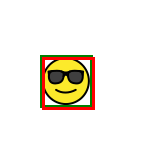

In [47]:
plot_bounding_box(x_train[i], [row_gt, col_gt], [row_p, col_p])

In [48]:
print(row_gt, col_gt)

45 30
